## Simulation Results
Here we present numerical simulations of a group of $N = 6$ robots manipulating a rigid body in $SE(3).$ We include implementations of both the typical adaptation law & one with l-p regularization.

In [6]:
#imports
using LinearAlgebra, NLsolve, Random, PyPlot, LaTeXStrings, PyCall
include("utils.jl")

vee (generic function with 1 method)

In [4]:
# using LinearAlgebra, NLsolve, Random, PyPlot, LaTeXStrings, PyCall
include("vectorfield.jl")

# curve = parametric_eq_circle(0.0)
# # acceleration([0, 0, 0], curve, 5, 2, 3, [1, 0, 0], 1e-3)

# println(a_d(x, dx, dt))
# println(v_d(x))
# _compute_ntd(curve, [0, 0, 0])

# pnorm_hessian(x, 2)
rand(6, 5)

6×5 Matrix{Float64}:
 0.229182   0.753479  0.888845   0.401085   0.00922696
 0.0394079  0.368358  0.613319   0.269816   0.319056
 0.45294    0.922294  0.0208541  0.560981   0.685993
 0.507597   0.209164  0.584864   0.0884073  0.974319
 0.368128   0.218908  0.825777   0.73333    0.0759528
 0.533531   0.364177  0.599495   0.725106   0.286628

### Physical Parameters & Constants

In [7]:
#Physical parameters
rho = 8050 #density, kg/m^3 
r = 0.5 #cylinder radius, m
h = 3. #cylinder height, m
m = rho*pi*(r^2)*h #cylinder mass, kg
num_freq = 1

fixed_sample = true #change to false if you want to study regularization; otherwise use true to replicate baselines

if fixed_sample
    r_p = [0,0,h/2] #measurement point
    N = 6
    r_i = [[0,0,h/2],[0,0,-h/2],[r,0,0],[-r,0,0],[0,r,0],[0,-r,0]]
else
    N_v = 10 #number of attachment points in vertical dim.
    N_h = 10 #number in horizontal dim
    N = N_v*N_h
    ~, r_i = sample_points(N_v,N_h,h,r,0.1) #seed robots semi-randomly around surface of cylinder
end

#compute inertia tensor
I_cm = (1/12)*Diagonal([m*(3*r^2+h^2),m*(3*r^2+h^2),6*m*r^2])
I_p = I_cm + m*(r_p'*r_p*I -r_p*r_p')

#frequencies & phase shifts for reference signal computation
freqs = rand(6,num_freq)
phases = zeros(6,num_freq)

#define  reference signals (combinations of sinusoids)
function w_d(t)
    return (1/length(freqs))*sum(vcat(cos.(freqs[1,:]*t.+phases[1,:])',sin.(freqs[2,:]*t.+phases[2,:])',cos.(freqs[3,:]*t.+phases[3,:])'),dims=2)[:]
end

function al_d(t)
    return (1/length(freqs))*sum(vcat(-freqs[1,:]'.*sin.(freqs[1,:]*t.+phases[1,:])',freqs[2,:]'.*cos.(freqs[2,:]*t.+phases[2,:])',-freqs[3,:]'.*sin.(freqs[3,:]*t.+phases[3,:])'),dims=2)[:]
end

# function v_d(t)
#    return (10/length(freqs))*sum(vcat(cos.(freqs[4,:]*t.+phases[4,:])',cos.(freqs[5,:]*t.+phases[5,:])',cos.(freqs[6,:]*t.+phases[6,:])'),dims=2)[:] 
# end

# function a_d(t)
#    return (10/length(freqs))*sum(vcat(-freqs[4,:]'.*sin.(freqs[4,:]*t.+phases[4,:])',-freqs[5,:]'.*sin.(freqs[5,:]*t.+phases[5,:])',-freqs[6,:]'.*sin.(freqs[6,:]*t.+phases[6,:])'),dims=2)[:]
# end

# function dq_des(t)
#     return vcat(v_d(t),w_d(t)) 
#  end
 
#  function ddq_des(t)
#     return vcat(a_d(t),al_d(t))
#  end

# VECTOR FIELD MOD
alpha = 1
const_vel = 0.1
function v_d(p)
    return _vector_field_vel(p, curve, alpha, const_vel, 3)
end

function a_d(p, velocity, dt)
    return acceleration(p, curve, alpha, const_vel, 3, velocity, dt)
end

function dq_des(t, p)
    return vcat(v_d(p),w_d(t)) 
end
    
function ddq_des(t, p, velocity, dt)
    return vcat(a_d(p, velocity, dt),al_d(t))
end

ddq_des (generic function with 1 method)

### Dynamics Implementation

In [8]:
function adaptive_dyn(x,x_d,R,R_d,dq,a_hat,r_hat,t;t_drop=Inf)
    #inputs: position x, desired pos. x_d, orientation R, des. orient. R_d, velocity dq, param estimates a_hat, r_hat, time t;
    #optional : drop time t_drop
    #outputs: state & parameter derivatives
    
    #unpack variables
    dx = deepcopy(dq[1:3])
    w = deepcopy(dq[4:6])
    
    #compute error signals
    Re = R_d'*R
    we = w - w_d(t)
    
    sigma = we + lambda*R_d*vee(Pa(Re))
    # dx_t = dx - v_d(t)
    dx_t = dx - v_d(x)   # VECTOR FIELD MOD
    x_t = x - x_d
    
    s = vcat(dx_t+lambda*x_t,sigma)
    
    al_r = al_d(t) - lambda*skew(w_d(t))*R_d*vee(Pa(Re)) - lambda*R_d*vee(Pa(skew(R_d'*we)*Re))
    w_r = w_d(t) - lambda*R_d*vee(Pa(Re))
    # a_r = a_d(t) - lambda*dx_t
    # v_r = v_d(t) - lambda*x_t
    a_r = a_d(x, dx, dt) - lambda*dx_t    # VECTOR FIELD MOD    
    v_r = v_d(x) - lambda*x_t    # VECTOR FIELD MOD
     
    ddq_r = vcat(a_r, al_r)
    dq_r = vcat(v_r, w_r)
    
    #compute regressors
    Y_l = hcat(a_r,-skew(al_r)*R-skew(w)*skew(w_r)*R,zeros(3,6))
    Y_r = hcat(zeros(3,1),skew(a_r)*R+skew(w)*skew(v_r)*R-skew(w_r)*skew(dx)*R,R*L(R'*al_r)+skew(w)*R*L(R'*w_r))
    Y_o = vcat(Y_l,Y_r)
    
    #compute true dynamics matrices
    H = vcat(hcat(m*I,m*skew(R*r_p)),
         hcat(-m*skew(R*r_p), R*I_p*R'))
        
    C = vcat(hcat(zeros(3,3),m*skew(w)*skew(R*r_p)),
        hcat(-m*skew(w)*skew(R*r_p),skew(w)*R*I_p*R'-m*skew(skew(R*r_p)*dx)))
    
    off_diag = m*skew(w)*R*skew(r_p)*R' - m*R*skew(r_p)*R'*skew(w)
    H_dot = vcat(hcat(zeros(3,3),off_diag),
                    hcat(-off_diag,skew(w)*R*I_p*R'-R*I_p*R'*skew(w)))
    
    #apply control law
    input = zeros(6)
    F = []
    
    for i = 1:N
        G = vcat(hcat(I,zeros(3,3)),hcat(skew(R*r_i[i]),I))
        G_h = vcat(hcat(I,zeros(3,3)),hcat(skew(R*r_hat[i]),I))
        G_h_inv = vcat(hcat(I,zeros(3,3)),hcat(-skew(R*r_hat[i]),I))

        push!(F,Y_o*a_hat[i] - Kd*s) #implement control law

        tau = G_h_inv*F[i]  #compensate for est. torque

        input += G*tau #compute real applied wrench; add to running
    end
    
    #use root finding to solve for accelerations (avoid inverting H)
    f(ddq) = H*ddq + C*dq - input
    ddq = nlsolve(f,zeros(6),autodiff=:forward).zero
    
    #implement adaptation laws
    Y_g, dr, a_t, r_t = [], [], [], []
    da, g_o, g_r = [], [], []
    
    for i = 1:N
        push!(Y_g,vcat(zeros(3,3),skew(F[i][1:3])*R)) #compute arm regressors
        #compute inverse Hessian weighting
        push!(g_o, inv(P_o)*inv(pnorm_hessian(P_o*a_hat[i],p,tol))*inv(P_o))
        push!(g_r, inv(P_r)*inv(pnorm_hessian(P_r*r_hat[i],p,tol))*inv(P_r))
        #compute param. derivatives and errors
        push!(da,-g_o[i]*Y_o'*s)
        push!(dr,-g_r[i]*Y_g[i]'*s)
        push!(a_t,a_hat[i]-a_i)
        push!(r_t,r_hat[i]-r_i[i])
    end
    
    ds = ddq - ddq_r
    # ds2 = vcat(ddq[1:3]-a_d(t)+lambda*(dx-v_d(t)),ddq[4:6]-al_d(t)+lambda*(skew(w_d(t))*R_d*vee(Pa(Re)) + R_d*vee(Pa(skew(R_d'*we)*Re))))
    ds2 = vcat(ddq[1:3]-a_d(x, dx, dt)+lambda*(dx - v_d(x)),ddq[4:6]-al_d(t)+lambda*(skew(w_d(t))*R_d*vee(Pa(Re)) + R_d*vee(Pa(skew(R_d'*we)*Re))))   # VECTOR FIELD MOD
    
    dV = s'*(-H*ddq_r - C*dq_r)
    dV2 = s'*H*ds + (1/2)*s'*H_dot*s
    r_err = 0
    o_err = 0
    
    for i = 1:N
        dV += s'*(F[i]+Y_g[i]*r_t[i])+ a_t[i]'*inv(g_o[i])*da[i] + r_t[i]'*inv(g_r[i])*dr[i]
        dV2 += a_t[i]'*inv(g_o[i])*da[i] + r_t[i]'*inv(g_r[i])*dr[i]
        o_err += abs(s'*Y_o*a_t[i] + a_t[i]'*P_o*pnorm_hessian(P_o*a_hat[i],p,tol)*P_o*da[i])
        r_err += abs(s'*Y_g[i]*r_t[i] + r_t[i]'*P_r*pnorm_hessian(P_r*r_hat[i],p,tol)*P_r*dr[i])
    end
    
    if verbose
    
        @show norm(H_dot-2*C+(H_dot-2*C)')/norm(H_dot-2*C) #check H_dot-2*C s.s.
        @show dV #check dV <= 0
        @show dV - dV2 #check dV equal when computed 2 different ways
        @show dV + N*s'*Kd*s #check dV = -N*s'*Kd*s
        @show norm(ds-ds2) #check ds equal when computed 2 different ways
        @show o_err, r_err #check parameter errors
    end
    
    #output accelerations & derivatives
    return ddq, da, dr, dV, ds
end

adaptive_dyn (generic function with 1 method)

### Run Simulations

In [9]:
#choose preset mode -- comment out to set parameters manually
sim_mode = :l2 #can be [:l2, :l1, :no_arms, :pd]

##setup constants, etc.
Random.seed!(318) #seed rand for repeatability

a_hat = [1*randn(10) for i = 1:N] #initial a_hat
if !fixed_sample
    a_hat = 100 .*a_hat
end
if sim_mode == :pd
    a_hat = [zeros(10) for i = 1:N]
end

#true a_i
a_I = [I_p[1,1], I_p[1,2], I_p[1,3], I_p[2,2], I_p[2,3], I_p[3,3]]
a = vcat(m,m*r_p,a_I)
a_i = (1/N)*a

#initial r_hat
r_hat = [2*randn(3) for i = 1:N]
if sim_mode == :pd
    r_hat = [zeros(3) for i = 1:N]
end
if !fixed_sample
    r_hat = 0.5 .* r_hat
end

#Kd matrix
Kd = Diagonal(vcat((5e4/N)*ones(3),(5e3/N)*ones(3)))

#sample random initial orientations
q = rand(4)
q = q/norm(q) #random quaternion
q_d = rand(4)
q_d = q_d/norm(q_d) #random desired quaternion
#cast both to rotation matrices
R = quat_to_rot(q)
R_d = quat_to_rot(q_d)

dq = zeros(6) #initial velocity = 0

#inital state
w = zeros(3)
x = zeros(3)
x_d = zeros(3)
dx = zeros(3)

#simulation parameters
dt = 1e-2 #timestep -- numerical integration via Heun's; error is ~ O(dt^2)
T = 0.01 #final time
verbose = true
lambda = 1.5 #sliding parameter
deadband = 0.01 #deadband in which to stop adaptation
t_drop = T+10 #time for drop -- use t_drop < T for agents to turn off

p = 2 #l-p norm to be used for regularization;
#note: we only implement l1, l2, since physical scaling issues => numerical problems for p > 2.

if sim_mode in [:l2, :no_arms, :pd]
    p = 2
elseif sim_mode == :l1
    p = 1.001
end

if p == 1.001
    P_o = 1e6*inv(Diagonal(abs.(a_i).+1e4)) #p = 1.001
    P_r = 1e6*inv(Diagonal(ones(3))) #p=1.001
    tol=1e-5
elseif p == 2
    P_o = 3e1*inv(Diagonal(abs.(a_i).+1e-2)) #p = 2
    P_r = 3e1*inv(Diagonal(ones(3))) #p=2
    tol=1e-5
end

if sim_mode in [:no_arms, :pd]
    P_r = 1e20*Diagonal(ones(3)) #essentially zero gain
    if sim_mode == :pd
        P_o = 1e20*Diagonal(abs.(a_i).+1e4)
        tol = 1e3
    end
end

#storage for sim. data
s_t = []
rot_err = []
V = []
global Vdot = []
s = zeros(6)
s_hat = []
Vhat = []
Vdot = []
lyap_params = []
lyap_dynamics = []
err_mean = []
param_est = []
arm_est = []
dV_params = []
dV_dynamics = []
hist_x = []
hist_dx = []
hist_vf = []

global H = vcat(hcat(m*I,m*skew(R*r_p)),
         hcat(-m*skew(R*r_p), R*I_p*R'))
verbose = false
dropped = false

for t in 0:dt:T
    if t >= t_drop && !dropped
        N = convert(Int,N/2)
        dropped = true
    end
    
    #unpack variables
    dx = deepcopy(dq[1:3])
    w = deepcopy(dq[4:6])
    #compute error signals
    Re = R_d'*R
    we = w - w_d(t)
    sigma = we + lambda*R_d*vee(Pa(Re))
    # dx_t = dx - v_d(t)
    dx_t = dx - v_d(x)   # VECTOR FIELD MOD
    x_t = x - x_d
    s = vcat(dx_t+lambda*x_t,sigma)
    vf_aux = v_d(x)
    
    #check if simulation has diverged -- if so, decrease dt
    if norm(s) > 1e3
        println(t)
        @warn "diverged"
        break
    end
    
    #dynamics matrices (for debug)
    H = vcat(hcat(m*I,m*skew(R*r_p)),
         hcat(-m*skew(R*r_p), R*I_p*R'))
    
    C = vcat(hcat(zeros(3,3),m*skew(w)*skew(R*r_p)),
        hcat(-m*skew(w)*skew(R*r_p),skew(w)*R*I_p*R'-m*skew(skew(R*r_p)*dx)))
    
    off_diag = m*skew(w)*R*skew(r_p)*R' - m*R*skew(r_p)*R'*skew(w)
    H_dot = vcat(hcat(zeros(3,3),off_diag),
                    hcat(-off_diag,skew(w)*R*I_p*R'-R*I_p*R'*skew(w)))
    
    #compute Lyap. function & param errors
    a_t = []
    r_t = []
    g_o = []
    g_r = []
    V_curr = 0.5*(s'*H*s)
    V_params = 0.
    
    for i = 1:N
        push!(g_o,inv(P_o)*inv(pnorm_hessian(P_o*a_hat[i],p,tol))*inv(P_o))
        push!(g_r,inv(P_r)*inv(pnorm_hessian(P_r*r_hat[i],p,tol))*inv(P_r))
        push!(a_t,a_hat[i]-a_i)
        push!(r_t,r_hat[i]-r_i[i])
        V_params += pnorm_divergence(P_o*a_i,P_o*a_hat[i],p,tol) + pnorm_divergence(P_r*r_i[i],P_r*r_hat[i],p,tol)
        V_curr += pnorm_divergence(P_o*a_i,P_o*a_hat[i],p,tol) + pnorm_divergence(P_r*r_i[i],P_r*r_hat[i],p,tol)
    end
    
    push!(V,V_curr)
    if t > 0
        lyap_arms = sum([pnorm_divergence(P_r*r_i[i],P_r*arm_est[end][1+3*(i-1):3*i],10,1e-10) for i = 1:N])
        lyap_obj = sum([pnorm_divergence(P_o*a_i,P_o*param_est[end][1+length(a_i)*(i-1):length(a_i)*i],10,1e-10) for i = 1:N])
    end

    at_mean = (1/N)*sum(a_t)
    rt_mean = (1/N)*sum(r_t)
    
    #logging
    push!(err_mean, norm(at_mean) + norm(rt_mean))
    push!(s_t,norm(s))
    push!(rot_err,norm(R_d'*R-I))
    push!(lyap_params,V_params)
    push!(lyap_dynamics,0.5*s'*H*s)
    
    #get dynamics @ current time
    ddq, da, dr, dV, ds = adaptive_dyn(x,x_d,R,R_d,dq,a_hat,r_hat,t)
    
    if t==0
        push!(Vhat,V[1])
        push!(s_hat,s)
    end
    
    a_int, r_int = [], []
        
    #intermediate step of Heun's
    for i = 1:N
        if norm(s) > deadband
            push!(a_int,a_hat[i] + dt*da[i])
            push!(r_int,r_hat[i] + dt*dr[i])
        else
            da[i] = 0*da[i]
            push!(a_int,a_hat[i])
            dr[i] = 0*dr[i]
            push!(r_int,r_hat[i])
        end
    end
    
    R_d_int = exp(dt*skew(w_d(t)))*R_d
    R_int = exp(dt*skew(w))*R
    
    # x_d_int = x_d + dt*v_d(t)
    x_d_int = x_d + dt*v_d(x)   # VECTOR FIELD MOD
    x_int = x + dt*dx
    dq_int = dq + dt*ddq
    
    dx_int = deepcopy(dq_int[1:3])
    w_int = deepcopy(dq_int[4:6])
    
    #second step of Heun's
    ddq_p, da_p, dr_p, dV_p, ds_p = adaptive_dyn(x_int,x_d_int,R_int,R_d_int,dq_int,a_int,r_int,t+dt)
    push!(Vhat,Vhat[end]+(dt/2)*(dV + dV_p))
    
    for i = 1:N
        if norm(s) > deadband #if above deadband, update parameters
            a_hat[i] = a_hat[i] + (dt/2)*(da[i]+da_p[i])
            r_hat[i] = r_hat[i] + (dt/2)*(dr[i]+dr_p[i])
        else
            da_p[i] = 0*da_p[i]
            dr_p[i] = 0*dr_p[i]
        end
    end
    
    push!(dV_dynamics,(1/2)*s'*H*(ds+ds_p) + (1/2)*s'*H_dot*s)
            
    vdot_params = 0.
    for i = 1:N
        vdot_params += (1/2)*a_t[i]'*inv(g_o[i])*(da[i]+da_p[i]) + (1/2)*r_t[i]'*inv(g_r[i])*(dr[i]+dr_p[i])
    end
            
    push!(dV_params,vdot_params)
    push!(s_hat,s_hat[end]+(dt/2)*(ds+ds_p))
    
    R_d = exp((dt/2)*skew(w_d(t)+w_d(t+dt)))*R_d
    R = exp((dt/2)*(skew(w)+skew(w_int)))*R
    
    # R = exp((dt)*(skew(w)))*R
    # R_d = exp((dt)*skew(w_d(t)))*R_d
    
    # x_d = x_d + (dt/2)*(v_d(t)+v_d(t+dt))
    x_d = x_d + (dt/2)*(v_d(x)+v_d(x_int))    # VECTOR FIELD MOD
    x = x + (dt/2)*(dx+dx_int)
    dq = dq + (dt/2)*(ddq+ddq_p)
    
    dx = deepcopy(dq[1:3])
    w = deepcopy(dq[4:6])
    
    push!(param_est, vcat([a_hat[i] for i = 1:N]...))
    push!(arm_est, vcat([r_hat[i] for i = 1:N]...))
    push!(hist_x,x)
    push!(hist_dx,dx)
    push!(hist_vf,vf_aux)

end
if sim_mode == :l1
    s_l1 = s_t;
    rot_l1 = rot_err;
    lyap_l1 = V;
    o_l1 = param_est;
    arm_l1 = arm_est;
elseif sim_mode == :l2
    s_l2 = s_t;
    rot_l2 = rot_err;
    lyap_l2 = V;
    o_l2 = param_est;
    arm_l2 = arm_est;
elseif sim_mode == :no_arms
    s_na = s_t;
    rot_na = rot_err;
    lyap_na = V;
    o_na = param_est;
    arm_na = arm_est;
elseif sim_mode == :pd
    s_pd = s_t;
    rot_pd = rot_err;
    lyap_pd = V;
    o_pd = param_est;
    arm_pd = arm_est;
end
return

UndefVarError: UndefVarError: `curve` not defined

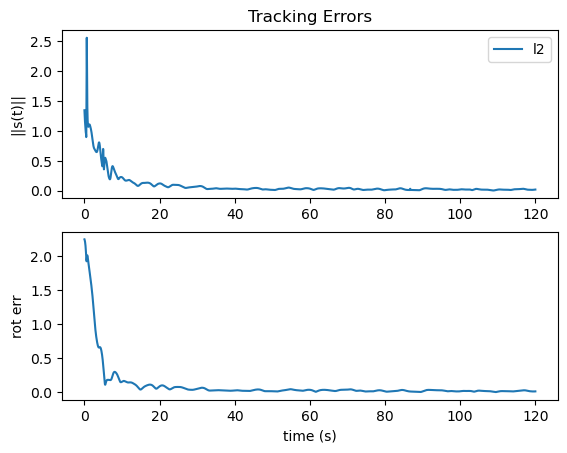

In [9]:
#error plot
t = 0:dt:T
fig, axs = PyPlot.subplots(2)
axs[1].set_ylabel("||s(t)||")
axs[1].set_title("Tracking Errors")
axs[1].plot(t,s_l2,label="l2")
# axs[1].plot(t,s_na,label="no arms")
# axs[1].plot(t,s_pd,label="pd")
axs[2].set_xlabel("time (s)")
axs[2].set_ylabel("rot err")
axs[2].plot(t,rot_l2);
# axs[2].plot(t,rot_na);
# axs[2].plot(t,rot_pd);
axs[1].legend()
display(fig)

In [201]:
# alpha_ = 10
# const_vel_ = 1

# vec_n, vec_t, min_dist = _compute_ntd(curve, x)
# fun_g = _INVHALFPI * atan(alpha_ * min_dist)
# fun_h = sqrt(max(1 - fun_g^2, 0))
# abs_const_vel = abs(const_vel_)
# sgn = const_vel_ / (abs_const_vel + 0.00001)
# result = abs_const_vel * (fun_g * vec_n + sgn * fun_h * vec_t)
# result
size(mat_x)

(3, 12001)

In [215]:
mat_x = hcat(hist_x...)
mat_vf = hcat(hist_vf...)
fig, axs = PyPlot.subplots(2)
axs[1].set_ylabel("x(t)")
axs[1].set_title("Tracking Errors")
axs[1].plot(t,mat_x',label="x")
# axs[1].plot(t,s_na,label="no arms")
# axs[1].plot(t,s_pd,label="pd")
axs[2].set_xlabel("time (s)")
axs[2].set_ylabel("dx(t)")
axs[2].plot(t, mat_vf');
# axs[2].plot(t,rot_na);
# axs[2].plot(t,rot_pd);
axs[1].legend()
display(fig)

# Create a scatter plot of X vs Y
fig2 = figure()
ax = fig2.add_subplot(111, projection="3d")
colors = collect(1:size(mat_x, 2))
# Plot the points in 3D
sc = ax.scatter(mat_x[1, :], mat_x[2, :], mat_x[3, :], c=colors, cmap="viridis")

# Add a color bar to show the color scale
cbar = fig.colorbar(sc)
cbar.set_label("Sample Index")
# Set labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Scatter Plot")

# Show the plot
display(fig2)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/fbartelt/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (12001,) and (111, 3)')
  File "/usr/lib/python3.11/site-packages/matplotlib/axes/_axes.py", line 1721, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/site-packages/matplotlib/axes/_base.py", line 303, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/site-packages/matplotlib/axes/_base.py", line 499, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


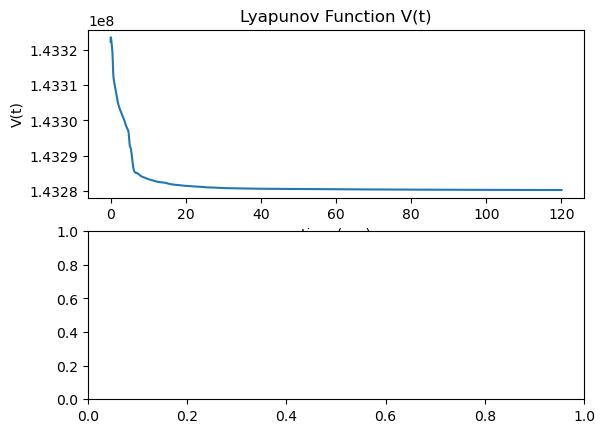

In [10]:
#Lyapunov function
fig, axs = PyPlot.subplots(2)
axs[1].plot(t,lyap_l2)
axs[1].set_title("Lyapunov Function V(t)")
axs[1].set_ylabel("V(t)")
axs[1].set_xlabel("time (sec)");
display(fig)

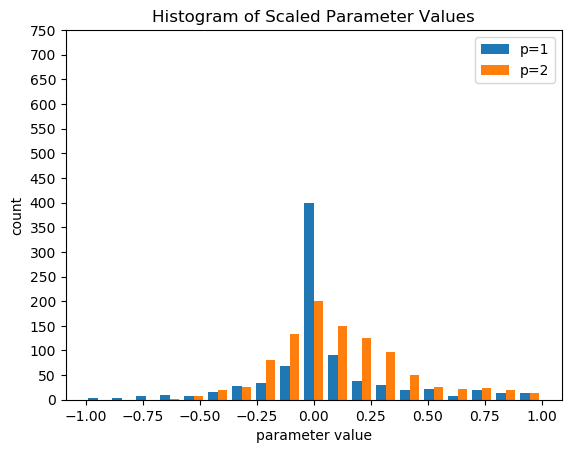

In [161]:
#run with N = 100
param_vals_l2 = reshape(o_l2[end],10,N)
rel_param_vals_l2 = 20*inv(Diagonal(abs.(a_i).+1e4))*param_vals_l2
param_vals_l1 = reshape(o_l1[end],10,N)
rel_param_vals_l1 = 20*inv(Diagonal(abs.(a_i).+1e4))*param_vals_l1
#param_vals_l50 = reshape(o_l50[end],10,100)
#rel_param_vals_l50 = inv(Diagonal(abs.(a_i).+1e4))*param_vals_l50
labels=["p=1", "p=2"]
vals = hcat(rel_param_vals_l1[:],rel_param_vals_l2[:])
PyPlot.hist(vals,bins=range(-1.,stop=1.,length=20),label=labels,histtype="bar")

PyPlot.xlabel("parameter value")
PyPlot.ylabel("count")
PyPlot.yticks(collect(0:50:750))
PyPlot.title("Histogram of Scaled Parameter Values")
PyPlot.legend()
PyPlot.savefig("./plots/histogram_combined.pdf",bbox_inches="tight")
#PyPlot.gca().set_xscale("log")